In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_squared_log_error


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
def create_sequences(data, time_steps=60):
    x = [data[i:i + time_steps] for i in range(len(data) - time_steps)]
    y = [data[i + time_steps] for i in range(len(data) - time_steps)]
    return np.array(x), np.array(y)

In [3]:
df=pd.read_csv('/kaggle/input/nvidia-daily-stock-price-data/nvidia_stock_prices.csv')
df.head()

Date      Open      High       Low     Close      Volume
0  2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
1  2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2  2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
3  2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
4  2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000

In [4]:
df['Date'] = pd.to_datetime(df.Date)
df.set_index('Date',inplace=True)
df

Open       High        Low      Close      Volume
Date                                                              
2004-01-02   0.196417   0.199083   0.192333   0.192333   436416000
2004-01-05   0.195250   0.199917   0.193500   0.198583   575292000
2004-01-06   0.198000   0.209417   0.197083   0.206667  1093344000
2004-01-07   0.204333   0.209500   0.202917   0.208500   673032000
2004-01-08   0.211083   0.212083   0.207250   0.209250   433752000
...               ...        ...        ...        ...         ...
2023-12-22  49.195000  49.382999  48.466999  48.830002   252507000
2023-12-26  48.967999  49.599998  48.959999  49.278999   244200000
2023-12-27  49.511002  49.680000  49.084999  49.417000   233648000
2023-12-28  49.643002  49.883999  49.411999  49.521999   246587000
2023-12-29  49.813000  49.997002  48.750999  49.521999   389293000

[5033 rows x 5 columns]

In [5]:
df.describe()

Open         High          Low        Close        Volume
count  5033.000000  5033.000000  5033.000000  5033.000000  5.033000e+03
mean      5.214671     5.308604     5.117086     5.217039  5.587962e+08
std       9.643976     9.811276     9.465058     9.644928  3.363408e+08
min       0.080583     0.083917     0.077500     0.078583  4.564400e+07
25%       0.344000     0.349000     0.336500     0.343250  3.482920e+08
50%       0.544000     0.552750     0.532500     0.542000  4.910920e+08
75%       5.233750     5.296500     5.125000     5.229000  6.816760e+08
max      50.216000    50.548000    49.411999    50.409000  5.088948e+09

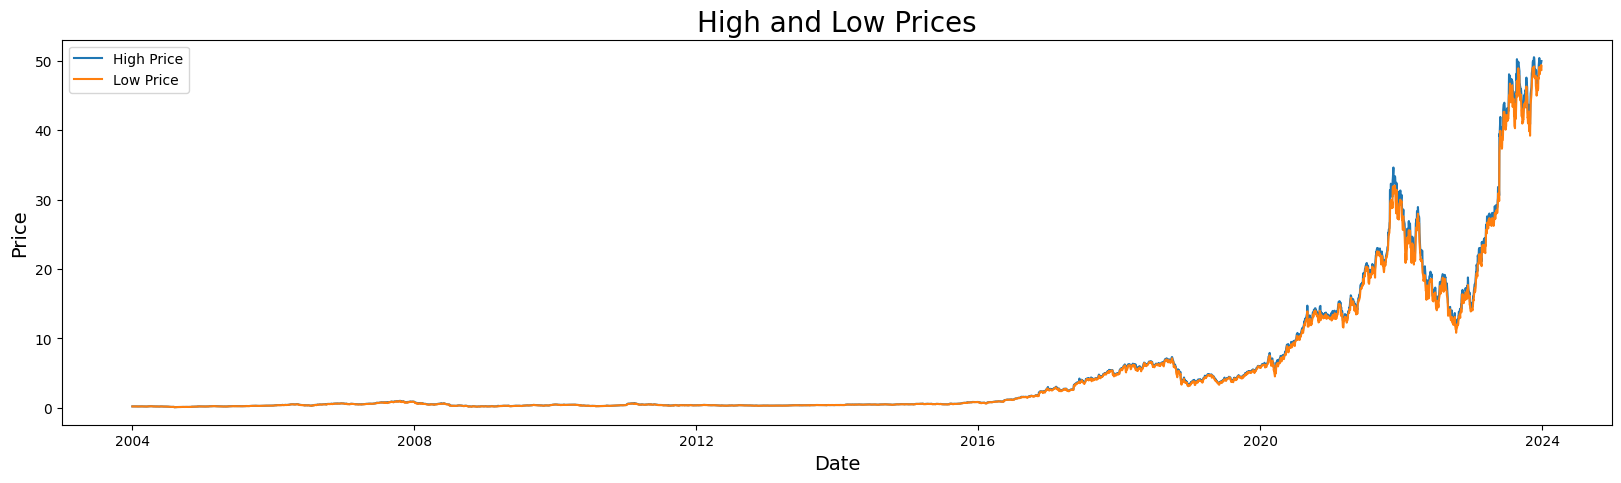

In [6]:
plt.figure(figsize=(20, 5))
plt.plot(df['High'], label='High Price')
plt.plot(df['Low'], label='Low Price')
plt.title('High and Low Prices', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='best') 

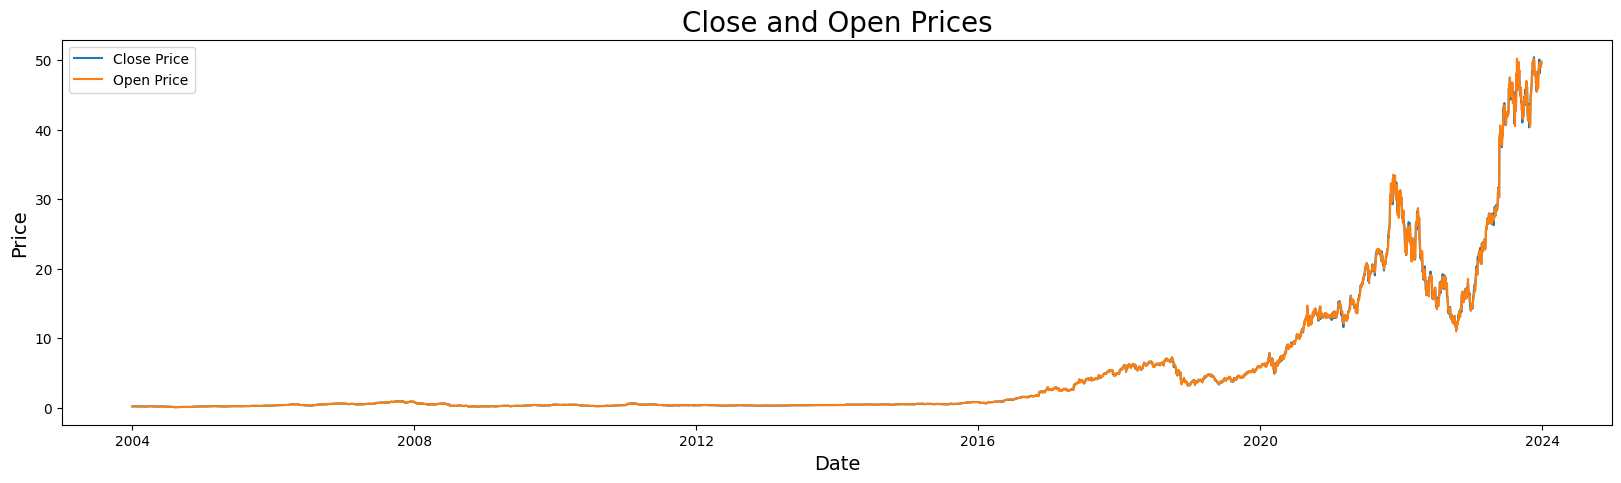

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Open'], label='Open Price')
plt.title('Close and Open Prices', fontsize=20)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(loc='best') 

Text(0, 0.5, 'Volume')

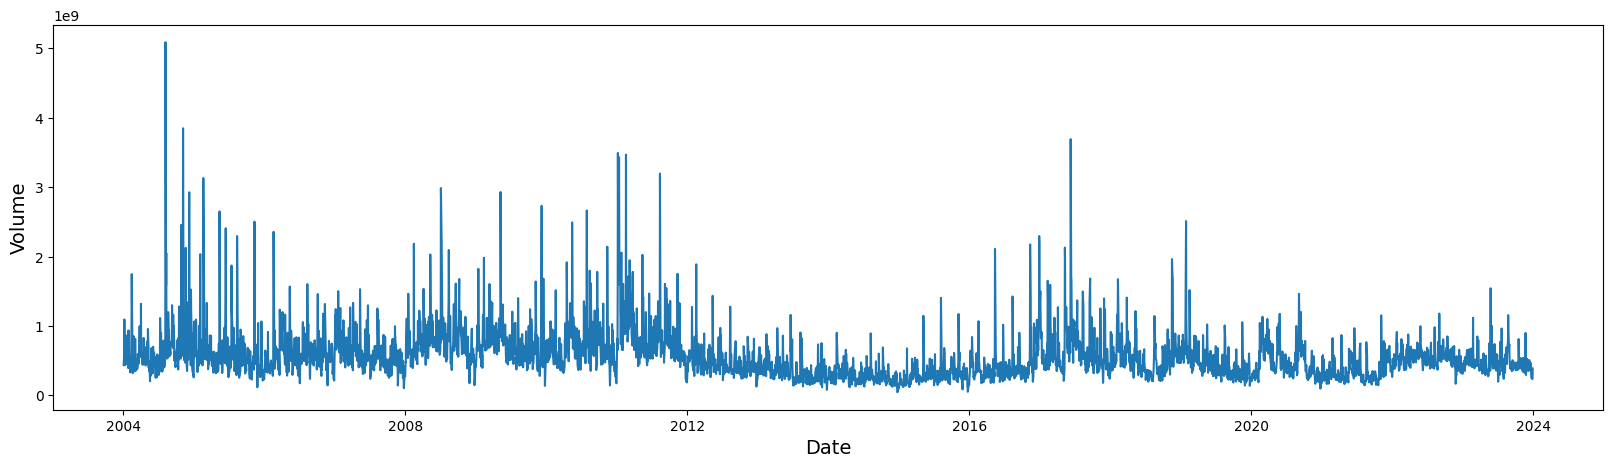

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(df['Volume'])
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)

In [9]:
df_univariate = df[['Close']]

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df_univariate)
x, y = create_sequences(df_scaled)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,shuffle=False)

In [12]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((3978, 60, 1), (995, 60, 1), (3978, 1), (995, 1))

In [13]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [14]:
model = Sequential([
    Input(shape= (x_train.shape[1], 1)),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(1),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [16]:
hist = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split = 0.1 ,callbacks = [early_stop],verbose=2)

Epoch 1/30
112/112 - 9s - 82ms/step - loss: 5.8274e-05 - val_loss: 5.9270e-05
Epoch 2/30
112/112 - 5s - 47ms/step - loss: 1.2441e-05 - val_loss: 7.5337e-05
Epoch 3/30
112/112 - 5s - 48ms/step - loss: 1.5277e-05 - val_loss: 3.9425e-05
Epoch 4/30
112/112 - 5s - 47ms/step - loss: 1.0710e-05 - val_loss: 4.1325e-05
Epoch 5/30
112/112 - 5s - 47ms/step - loss: 1.1296e-05 - val_loss: 3.4516e-05
Epoch 6/30
112/112 - 5s - 46ms/step - loss: 1.1642e-05 - val_loss: 3.3654e-05
Epoch 7/30
112/112 - 5s - 47ms/step - loss: 9.8870e-06 - val_loss: 3.2018e-05
Epoch 8/30
112/112 - 5s - 47ms/step - loss: 1.1055e-05 - val_loss: 3.8006e-05
Epoch 9/30
112/112 - 5s - 49ms/step - loss: 9.4153e-06 - val_loss: 3.6442e-05


<Axes: >

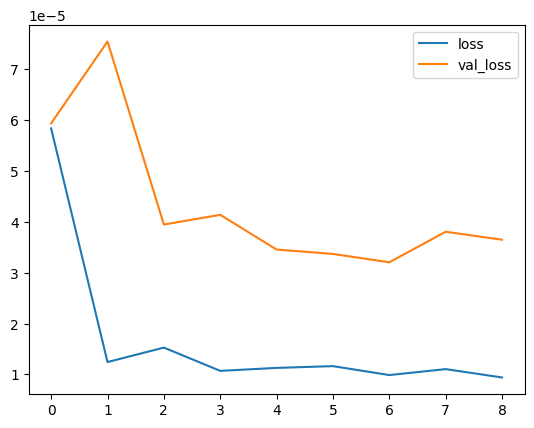

In [17]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [18]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

actual_prices = scaler.inverse_transform(y_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


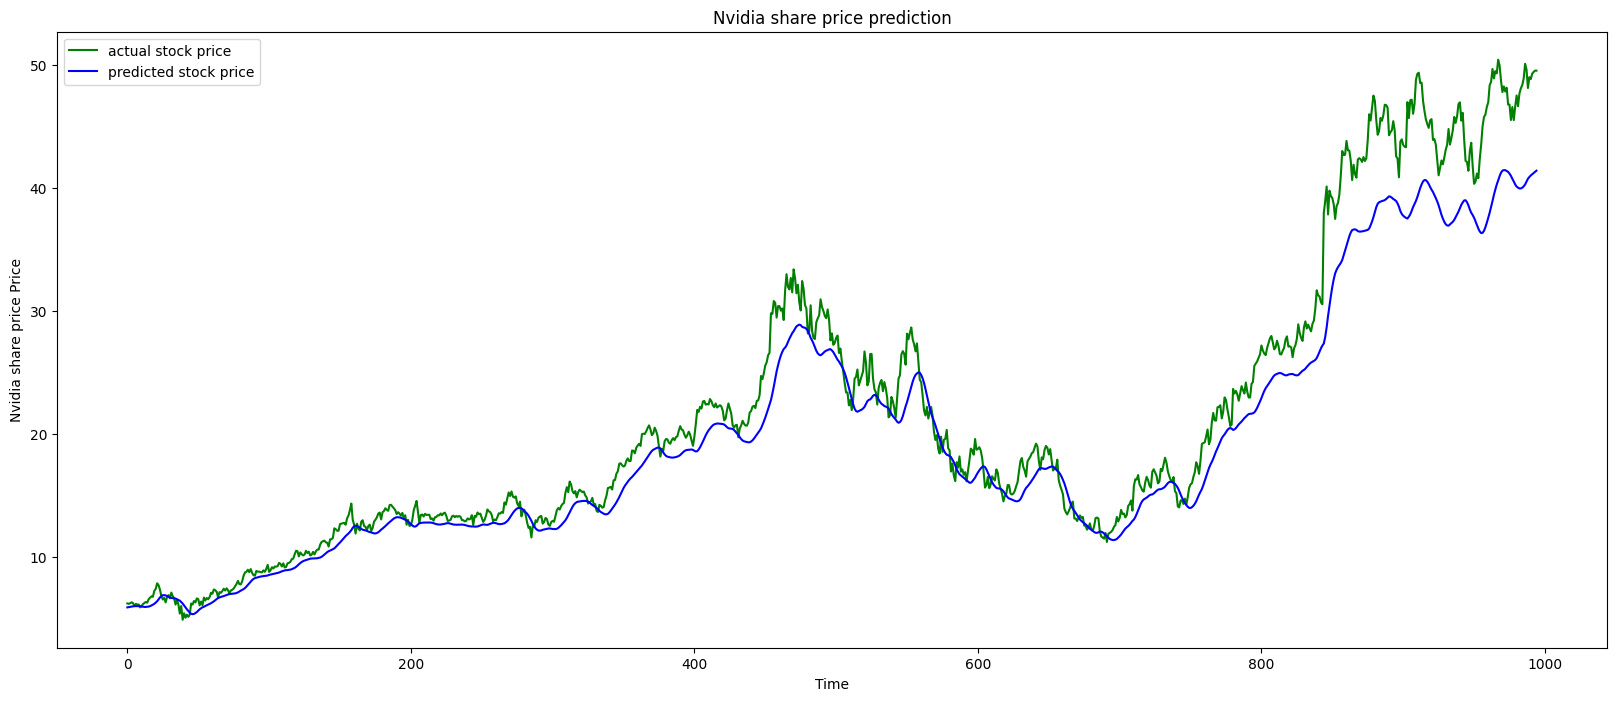

In [19]:
plt.figure(figsize= (20,8))
plt.plot(actual_prices, color = 'green', label = 'actual stock price')
plt.plot(predictions, color = 'blue', label = 'predicted stock price')
plt.title('Nvidia share price prediction')
plt.xlabel('Time')
plt.ylabel('Nvidia share price Price')
plt.legend()
plt.show()

In [20]:
test_results = pd.DataFrame({
    'Actual': actual_prices.flatten(),
    'Predicted': predictions.flatten()
}, index=pd.date_range(start=df.index[-len(actual_prices)] + pd.DateOffset(1), periods=len(actual_prices), freq='ME'))

test_results

Actual  Predicted
2020-01-31   6.232000   5.911994
2020-02-29   6.198500   5.936676
2020-03-31   6.252750   5.957139
2020-04-30   6.321500   5.976830
2020-05-31   6.262000   5.998891
...               ...        ...
2102-07-31  48.830002  41.007835
2102-08-31  49.278999  41.106277
2102-09-30  49.417000  41.204033
2102-10-31  49.521999  41.300274
2102-11-30  49.521999  41.393848

[995 rows x 2 columns]

In [21]:
mse = mean_squared_error(actual_prices, predictions)
mae = mean_absolute_error(actual_prices, predictions)
rmse = np.sqrt(mse)
rlmse=mean_squared_log_error(actual_prices, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Root Mean Squared log Error: {rlmse}')

Mean Squared Error: 10.565463219840227
Mean Absolute Error: 2.2283981927076177
Root Mean Squared Error: 3.250455848006588
Root Mean Squared log Error: 0.011097205099008842


Multivariate

In [22]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)
x, y = create_sequences(df_scaled)

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,shuffle=False)

In [24]:
model = Sequential([
    Input(shape= (x_train.shape[1], x_train.shape[2])),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=False),
    Dropout(0.2),
    Dense(y_train.shape[1]),
])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,655 (123.65 KB)

 Trainable params: 31,655 (123.65 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [26]:
model.hist = model.fit(x_train, y_train, epochs=30, batch_size=32, validation_split = 0.1 ,callbacks = [early_stop],verbose=2)

Epoch 1/30
112/112 - 9s - 83ms/step - loss: 0.0011 - val_loss: 5.1492e-04
Epoch 2/30
112/112 - 5s - 48ms/step - loss: 8.5628e-04 - val_loss: 4.3181e-04


<Axes: >

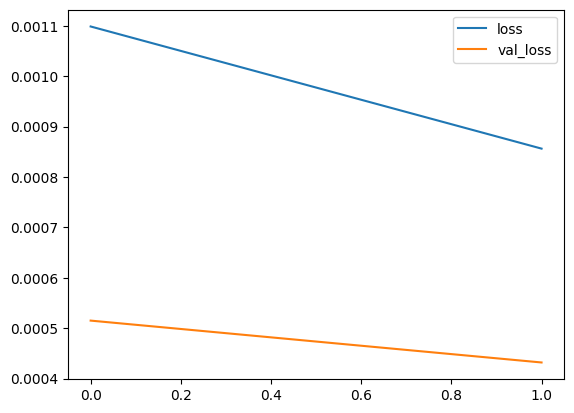

In [27]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [28]:
predictions = model.predict(x_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


In [29]:
test_results = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': predictions.flatten()
})

test_results

Actual  Predicted
0     0.122905   0.117045
1     0.122188   0.116906
2     0.123783   0.114013
3     0.122260   0.118261
4     0.041272   0.066640
...        ...        ...
4970  0.991962   0.718262
4971  0.989081   0.739045
4972  0.986602   0.678816
4973  0.982376   0.722006
4974  0.068140   0.126322

[4975 rows x 2 columns]

In [30]:
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)
rlmse=mean_squared_log_error(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Root Mean Squared log Error: {rlmse}')

Mean Squared Error: 0.00837397489667559
Mean Absolute Error: 0.05916710277948829
Root Mean Squared Error: 0.0915094251794622
Root Mean Squared log Error: 0.0030893318116976256
